In [11]:
from air_quality_preprocessor_forecasting import AirQualityPreprocessor
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [12]:
# df = pd.read_csv('Solicitud_Historica/Historico_pm25_filtered.csv', sep=';')
df = pd.read_csv('siata_merged_data.csv', sep=';')

h = 24  # 24-hour ahead

# # Rename the first column to 'Fecha_Hora'
# df.rename(columns={df.columns[0]: 'Fecha_Hora'}, inplace=True)

# # Convert 'Fecha_Hora' to datetime
# df['Fecha_Hora'] = pd.to_datetime(df['Fecha_Hora'], format='%d/%m/%y %H:%M')
# df=df[[
#     'Fecha_Hora',
#     'pm25','calidad_pm25',
#     'nox', 'calidad_nox',
#     'vviento_ssr', 'calidad_vviento_ssr',
#     'no2', 'calidad_no2',
#     'no', 'calidad_no',
#     'haire10_ssr', 'calidad_haire10_ssr'
#     ]]

# df=df[[
#     'Fecha_Hora',
#     'pm25','calidad_pm25',
#     'nox', 'calidad_nox',
#     'no2', 'calidad_no2',
#     'no', 'calidad_no',
#     ]]

# df=df[[
#     'Fecha_Hora',
#     'pm25','calidad_pm25',
#     ]]

In [13]:
df.head()

,Fecha_Hora,BEL-USBV__DViento_SSR,BEL-USBV__P_SSR,BEL-USBV__RGlobal_SSR,BEL-USBV__TAire10_SSR,BEL-USBV__VViento_SSR,ITA-CJUS__DViento_SSR,ITA-CJUS__HAire10_SSR,ITA-CJUS__P_SSR,ITA-CJUS__RGlobal_SSR,...,MED-SELE__PM2.5,MED-ALTA__PM2.5,MED-TESO__PM2.5,ITA-CJUS__PM2.5,MED-LAYE__PM2.5,ITA-CONC__PM2.5,ENV-HOSP__PM2.5,EST-HOSP__PM2.5,SAB-RAME__PM2.5,CAL-JOAR__PM2.5
0,2019-01-01 00:00:00,238.021,638.151,0.0,16.9139,1.70541,182.248,56.9499,634.559,0.0,...,NaN,77.0134,26.6834,171.0,17.0,79.0,44.5809,28.0,62.7140,NaN
1,2019-01-01 01:00:00,228.520,637.776,0.0,15.9597,1.54506,170.824,59.6667,634.183,0.0,...,NaN,36.6871,23.0106,198.0,22.0,74.0,44.5023,19.0,44.5194,NaN
2,2019-01-01 02:00:00,228.798,637.315,0.0,15.3926,1.67008,180.863,63.7678,633.785,0.0,...,NaN,39.0220,20.5705,160.0,11.0,56.0,44.4149,27.0,45.7275,NaN
3,2019-01-01 03:00:00,229.850,636.847,0.0,14.8924,1.56168,194.199,66.2271,633.444,0.0,...,NaN,36.6138,20.5436,155.0,22.0,37.0,41.9547,31.0,58.8523,31.6231
4,2019-01-01 04:00:00,229.380,636.912,0.0,14.6778,1.69733,223.200,70.3917,633.410,0.0,...,NaN,27.0872,19.2904,115.0,21.0,43.0,35.9086,22.0,85.0434,29.0643


In [14]:
# # Make sure timestamp is datetime
# df["Fecha_Hora"] = pd.to_datetime(df["Fecha_Hora"])

train_start = "2019-01-01"
train_end   = "2021-12-31"

test_start  = "2022-01-01"
test_end    = "2023-12-31"

val_start   = "2024-01-01"
val_end     = "2024-12-31"

mask_train = (df["Fecha_Hora"] >= train_start) & (df["Fecha_Hora"] <= train_end)
mask_test  = (df["Fecha_Hora"] >= test_start)  & (df["Fecha_Hora"] <= test_end)
mask_val   = (df["Fecha_Hora"] >= val_start)   & (df["Fecha_Hora"] <= val_end)

df_train = df.loc[mask_train].copy()
df_test  = df.loc[mask_test].copy()
df_val   = df.loc[mask_val].copy()

In [15]:
df_train[[col for col in df.columns if col.startswith('ITA-CJUS')]].head()

,ITA-CJUS__DViento_SSR,ITA-CJUS__HAire10_SSR,ITA-CJUS__P_SSR,ITA-CJUS__RGlobal_SSR,ITA-CJUS__TAire10_SSR,ITA-CJUS__VViento_SSR,ITA-CJUS__PM2.5
0,182.248,56.9499,634.559,0.0,19.5628,0.373759,171.0
1,170.824,59.6667,634.183,0.0,19.0364,0.380545,198.0
2,180.863,63.7678,633.785,0.0,18.2107,0.209423,160.0
3,194.199,66.2271,633.444,0.0,17.5893,0.344507,155.0
4,223.200,70.3917,633.410,0.0,16.7994,0.270756,115.0


# ITA-CJUS

In [16]:
preproc_ita_cjus = AirQualityPreprocessor(
    target_col="ITA-CJUS__PM2.5",      # or any other station column
    auxiliary_stations=[
        'MED-ARAN',
        'CAL-JOAR',
        'MED-BEME',
        'ITA-CONC'
    ],
    datetime_col="Fecha_Hora",  # the time column in your file
    freq='1H',                  # or "1H" if you want to enforce hourly frequency
    horizon=h,                 # forecast horizon (24 hours ahead)
    time_features_at="t+h",    # time features at forecast time
    lags=[1, 2, 3, 4, 5, 6, 21, 22, 23, 24, 47, 48, 168],                 # pm25_lag1..24 and lags for other numeric vars
    dropna_target=True,        # drop rows with missing target values
    lag_other_cols=None,        # None = lag all numeric columns except target
    missing_col_threshold=0.5, # or e.g. 0.5 to drop very sparse columns
    rolling_windows=[3, 6, 24, 48, 168],  # rolling mean features
)


# VERY IMPORTANT: fit ONLY on training data (2019–2021)
preproc_ita_cjus.fit(df_train)

Target prefix: ITA-CJUS
Auxiliary stations specified, using PM2.5 columns: ['MED-ARAN__PM2.5', 'CAL-JOAR__PM2.5', 'MED-BEME__PM2.5', 'ITA-CONC__PM2.5']
Station columns: ['ITA-CJUS__DViento_SSR', 'ITA-CJUS__HAire10_SSR', 'ITA-CJUS__P_SSR', 'ITA-CJUS__RGlobal_SSR', 'ITA-CJUS__TAire10_SSR', 'ITA-CJUS__VViento_SSR', 'ITA-CJUS__PM2.5']
Selected columns: ['ITA-CJUS__DViento_SSR', 'ITA-CJUS__HAire10_SSR', 'ITA-CJUS__P_SSR', 'ITA-CJUS__RGlobal_SSR', 'ITA-CJUS__TAire10_SSR', 'ITA-CJUS__VViento_SSR', 'MED-ARAN__PM2.5', 'MED-BEME__PM2.5', 'ITA-CJUS__PM2.5', 'ITA-CONC__PM2.5', 'CAL-JOAR__PM2.5']


/home/manuel/Documents/Maestria_Analitica/Semestre_II/AQI_Predict/air_quality_preprocessor_forecasting.py:93: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.asfreq(self.freq)
/home/manuel/Documents/Maestria_Analitica/Semestre_II/AQI_Predict/air_quality_preprocessor_forecasting.py:165: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(self.freq)


AirQualityPreprocessor(auxiliary_stations=['MED-ARAN', 'CAL-JOAR', 'MED-BEME',
                                           'ITA-CONC'],
                       datetime_col='Fecha_Hora', dropna_target=True, freq='1H',
                       horizon=24,
                       lags=[1, 2, 3, 4, 5, 6, 21, 22, 23, 24, 47, 48, 168],
                       missing_col_threshold=0.5,
                       rolling_windows=[3, 6, 24, 48, 168],
                       target_col='ITA-CJUS__PM2.5', time_features_at='t+h')

In [17]:
# Train
X_train_ita_cjus, y_train_ita_cjus, mask_train_valid_ita_cjus, idx_train_ita_cjus = preproc_ita_cjus.transform(df_train)

# Test (2022–2023)
X_test_ita_cjus, y_test_ita_cjus, mask_test_valid_ita_cjus, idx_test_ita_cjus = preproc_ita_cjus.transform(df_test)

# Validation (2024)
X_val_ita_cjus, y_val_ita_cjus, mask_val_valid_ita_cjus, idx_val_ita_cjus = preproc_ita_cjus.transform(df_val)


/home/manuel/Documents/Maestria_Analitica/Semestre_II/AQI_Predict/air_quality_preprocessor_forecasting.py:93: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.asfreq(self.freq)
/home/manuel/Documents/Maestria_Analitica/Semestre_II/AQI_Predict/air_quality_preprocessor_forecasting.py:165: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(self.freq)


Target prefix: ITA-CJUS
Auxiliary stations specified, using PM2.5 columns: ['MED-ARAN__PM2.5', 'CAL-JOAR__PM2.5', 'MED-BEME__PM2.5', 'ITA-CONC__PM2.5']
Station columns: ['ITA-CJUS__DViento_SSR', 'ITA-CJUS__HAire10_SSR', 'ITA-CJUS__P_SSR', 'ITA-CJUS__RGlobal_SSR', 'ITA-CJUS__TAire10_SSR', 'ITA-CJUS__VViento_SSR', 'ITA-CJUS__PM2.5']
Selected columns: ['ITA-CJUS__DViento_SSR', 'ITA-CJUS__HAire10_SSR', 'ITA-CJUS__P_SSR', 'ITA-CJUS__RGlobal_SSR', 'ITA-CJUS__TAire10_SSR', 'ITA-CJUS__VViento_SSR', 'MED-ARAN__PM2.5', 'MED-BEME__PM2.5', 'ITA-CJUS__PM2.5', 'ITA-CONC__PM2.5', 'CAL-JOAR__PM2.5']


/home/manuel/Documents/Maestria_Analitica/Semestre_II/AQI_Predict/air_quality_preprocessor_forecasting.py:93: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.asfreq(self.freq)
/home/manuel/Documents/Maestria_Analitica/Semestre_II/AQI_Predict/air_quality_preprocessor_forecasting.py:165: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(self.freq)
/home/manuel/Documents/Maestria_Analitica/Semestre_II/AQI_Predict/air_quality_preprocessor_forecasting.py:93: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.asfreq(self.freq)
/home/manuel/Documents/Maestria_Analitica/Semestre_II/AQI_Predict/air_quality_preprocessor_forecasting.py:165: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(self.freq)


Target prefix: ITA-CJUS
Auxiliary stations specified, using PM2.5 columns: ['MED-ARAN__PM2.5', 'CAL-JOAR__PM2.5', 'MED-BEME__PM2.5', 'ITA-CONC__PM2.5']
Station columns: ['ITA-CJUS__DViento_SSR', 'ITA-CJUS__HAire10_SSR', 'ITA-CJUS__P_SSR', 'ITA-CJUS__RGlobal_SSR', 'ITA-CJUS__TAire10_SSR', 'ITA-CJUS__VViento_SSR', 'ITA-CJUS__PM2.5']
Selected columns: ['ITA-CJUS__DViento_SSR', 'ITA-CJUS__HAire10_SSR', 'ITA-CJUS__P_SSR', 'ITA-CJUS__RGlobal_SSR', 'ITA-CJUS__TAire10_SSR', 'ITA-CJUS__VViento_SSR', 'MED-ARAN__PM2.5', 'MED-BEME__PM2.5', 'ITA-CJUS__PM2.5', 'ITA-CONC__PM2.5', 'CAL-JOAR__PM2.5']
Target prefix: ITA-CJUS
Auxiliary stations specified, using PM2.5 columns: ['MED-ARAN__PM2.5', 'CAL-JOAR__PM2.5', 'MED-BEME__PM2.5', 'ITA-CONC__PM2.5']
Station columns: ['ITA-CJUS__DViento_SSR', 'ITA-CJUS__HAire10_SSR', 'ITA-CJUS__P_SSR', 'ITA-CJUS__RGlobal_SSR', 'ITA-CJUS__TAire10_SSR', 'ITA-CJUS__VViento_SSR', 'ITA-CJUS__PM2.5']
Selected columns: ['ITA-CJUS__DViento_SSR', 'ITA-CJUS__HAire10_SSR', 'ITA-CJ

In [18]:
# Base feature matrices as DataFrames
X_train_h_ita_cjus = X_train_ita_cjus[preproc_ita_cjus.feature_cols_]
X_test_h_ita_cjus  = X_test_ita_cjus[preproc_ita_cjus.feature_cols_]
X_val_h_ita_cjus   = X_val_ita_cjus[preproc_ita_cjus.feature_cols_]

y_train_h_ita_cjus = y_train_ita_cjus
y_test_h_ita_cjus  = y_test_ita_cjus
y_val_h_ita_cjus   = y_val_ita_cjus

In [19]:
# # --- build 24-hour-ahead targets ---

# # Training: X at time t, y at time t+6
# X_train_h_ita_cjus = X_train_full_ita_cjus.iloc[:-h]        # drop last h rows (no future target)
# y_train_h_ita_cjus = y_train_full_ita_cjus[h:]             # drop first h rows

# # keep only rows where the 6h-ahead target is valid (not NaN)
# mask_train_h_ita_cjus = ~np.isnan(y_train_h_ita_cjus)
# X_train_h_ita_cjus = X_train_h_ita_cjus.loc[mask_train_h_ita_cjus]
# y_train_h_ita_cjus = y_train_h_ita_cjus[mask_train_h_ita_cjus]

# # Test: same logic
# X_test_h_ita_cjus = X_test_full_ita_cjus.iloc[:-h]
# y_test_h_ita_cjus = y_test_full_ita_cjus[h:]

# mask_test_h_ita_cjus = ~np.isnan(y_test_h_ita_cjus)
# X_test_h_ita_cjus = X_test_h_ita_cjus.loc[mask_test_h_ita_cjus]
# y_test_h_ita_cjus = y_test_h_ita_cjus[mask_test_h_ita_cjus]

# # Validation: same logic
# X_val_h_ita_cjus = X_val_full_ita_cjus.iloc[:-h]
# y_val_h_ita_cjus = y_val_full_ita_cjus[h:]

# mask_val_h_ita_cjus = ~np.isnan(y_val_h_ita_cjus)
# X_val_h_ita_cjus = X_val_h_ita_cjus.loc[mask_val_h_ita_cjus]
# y_val_h_ita_cjus = y_val_h_ita_cjus[mask_val_h_ita_cjus]

In [20]:
y_train_ita_cjus

array([19., 17., 19., ..., 25., 38., 38.])

In [21]:
preproc_ita_cjus.predictor_columns_

['ITA-CJUS__DViento_SSR',
 'ITA-CJUS__HAire10_SSR',
 'ITA-CJUS__P_SSR',
 'ITA-CJUS__RGlobal_SSR',
 'ITA-CJUS__TAire10_SSR',
 'ITA-CJUS__VViento_SSR',
 'MED-ARAN__PM2.5',
 'MED-BEME__PM2.5',
 'ITA-CJUS__PM2.5',
 'ITA-CONC__PM2.5',
 'CAL-JOAR__PM2.5']

In [22]:
preproc_ita_cjus.feature_cols_

['ITA-CJUS__DViento_SSR',
 'ITA-CJUS__HAire10_SSR',
 'ITA-CJUS__P_SSR',
 'ITA-CJUS__RGlobal_SSR',
 'ITA-CJUS__TAire10_SSR',
 'ITA-CJUS__VViento_SSR',
 'MED-ARAN__PM2.5',
 'MED-BEME__PM2.5',
 'ITA-CONC__PM2.5',
 'CAL-JOAR__PM2.5',
 'hour',
 'dayofweek',
 'month',
 'dayofyear',
 'hour_sin',
 'hour_cos',
 'doy_sin',
 'doy_cos',
 'ITA-CJUS__PM2.5_lag1',
 'ITA-CJUS__PM2.5_lag2',
 'ITA-CJUS__PM2.5_lag3',
 'ITA-CJUS__PM2.5_lag4',
 'ITA-CJUS__PM2.5_lag5',
 'ITA-CJUS__PM2.5_lag6',
 'ITA-CJUS__PM2.5_lag21',
 'ITA-CJUS__PM2.5_lag22',
 'ITA-CJUS__PM2.5_lag23',
 'ITA-CJUS__PM2.5_lag24',
 'ITA-CJUS__PM2.5_lag47',
 'ITA-CJUS__PM2.5_lag48',
 'ITA-CJUS__PM2.5_lag168',
 'ITA-CJUS__DViento_SSR_lag1',
 'ITA-CJUS__DViento_SSR_lag2',
 'ITA-CJUS__DViento_SSR_lag3',
 'ITA-CJUS__DViento_SSR_lag4',
 'ITA-CJUS__DViento_SSR_lag5',
 'ITA-CJUS__DViento_SSR_lag6',
 'ITA-CJUS__DViento_SSR_lag21',
 'ITA-CJUS__DViento_SSR_lag22',
 'ITA-CJUS__DViento_SSR_lag23',
 'ITA-CJUS__DViento_SSR_lag24',
 'ITA-CJUS__DViento_SSR_la

In [ ]:
numeric_cols_ita_cjus = preproc_ita_cjus.feature_cols_

numeric_transformer_ita_cjus = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),  # RF-specific choice
])

col_transformer_ita_cjus = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_ita_cjus, numeric_cols_ita_cjus),
    ]
)

rf_pipeline_ita_cjus = Pipeline([
    ("cols", col_transformer_ita_cjus),
    ("rf", RandomForestRegressor())
])

In [15]:
param_grid_ita_cjus = {
    'rf__n_estimators': [100],
    'rf__max_depth': [50],
    'rf__min_samples_split': [10],
    'rf__criterion': ['squared_error']
}

grid_search_ita_cjus = GridSearchCV(rf_pipeline_ita_cjus, param_grid_ita_cjus, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=2)
grid_search_ita_cjus.fit(X_train_h_ita_cjus, y_train_h_ita_cjus)

best_rf_pipeline_ita_cjus = grid_search_ita_cjus.best_estimator_
print("Best parameters found for ITA-CJUS: ", grid_search_ita_cjus.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END rf__criterion=squared_error, rf__max_depth=50, rf__min_samples_split=10, rf__n_estimators=100; total time= 1.9min
[CV] END rf__criterion=squared_error, rf__max_depth=50, rf__min_samples_split=10, rf__n_estimators=100; total time= 1.9min
[CV] END rf__criterion=squared_error, rf__max_depth=50, rf__min_samples_split=10, rf__n_estimators=100; total time= 2.0min
[CV] END rf__criterion=squared_error, rf__max_depth=50, rf__min_samples_split=10, rf__n_estimators=100; total time= 2.1min
[CV] END rf__criterion=squared_error, rf__max_depth=50, rf__min_samples_split=10, rf__n_estimators=100; total time= 2.1min
Best parameters found for ITA-CJUS:  {'rf__criterion': 'squared_error', 'rf__max_depth': 50, 'rf__min_samples_split': 10, 'rf__n_estimators': 100}


In [16]:
# Evaluate on 2022–2023
y_test_pred_ita_cjus = best_rf_pipeline_ita_cjus.predict(X_test_h_ita_cjus)
rmse_test_ita_cjus = root_mean_squared_error(y_test_h_ita_cjus, y_test_pred_ita_cjus)
# Evaluate on 2024
y_val_pred_ita_cjus = best_rf_pipeline_ita_cjus.predict(X_val_h_ita_cjus)
rmse_val_ita_cjus = root_mean_squared_error(y_val_h_ita_cjus, y_val_pred_ita_cjus)
print("RMSE test (2022–2023):", rmse_test_ita_cjus)
print("RMSE val  (2024):", rmse_val_ita_cjus)

# Evaluate R2
r2_train_ita_cjus = r2_score(y_train_h_ita_cjus, best_rf_pipeline_ita_cjus.predict(X_train_h_ita_cjus))
r2_test_ita_cjus = r2_score(y_test_h_ita_cjus, y_test_pred_ita_cjus)
r2_val_ita_cjus = r2_score(y_val_h_ita_cjus, y_val_pred_ita_cjus)
print("R2 train (2019–2021):", r2_train_ita_cjus)
print("R2 test (2022–2023):", r2_test_ita_cjus)
print("R2 val  (2024):", r2_val_ita_cjus)

RMSE test (2022–2023): 10.982534644586607
RMSE val  (2024): 10.073414657402937
R2 train (2019–2021): 0.8745465377968713
R2 test (2022–2023): 0.17039573834791877
R2 val  (2024): 0.28563863427075775


In [17]:
df_train.head()

,Fecha_Hora,BEL-USBV__DViento_SSR,BEL-USBV__P_SSR,BEL-USBV__RGlobal_SSR,BEL-USBV__TAire10_SSR,BEL-USBV__VViento_SSR,ITA-CJUS__DViento_SSR,ITA-CJUS__HAire10_SSR,ITA-CJUS__P_SSR,ITA-CJUS__RGlobal_SSR,...,MED-SELE__PM2.5,MED-ALTA__PM2.5,MED-TESO__PM2.5,ITA-CJUS__PM2.5,MED-LAYE__PM2.5,ITA-CONC__PM2.5,ENV-HOSP__PM2.5,EST-HOSP__PM2.5,SAB-RAME__PM2.5,CAL-JOAR__PM2.5
0,2019-01-01 00:00:00,238.021,638.151,0.0,16.9139,1.70541,182.248,56.9499,634.559,0.0,...,NaN,77.0134,26.6834,171.0,17.0,79.0,44.5809,28.0,62.7140,NaN
1,2019-01-01 01:00:00,228.520,637.776,0.0,15.9597,1.54506,170.824,59.6667,634.183,0.0,...,NaN,36.6871,23.0106,198.0,22.0,74.0,44.5023,19.0,44.5194,NaN
2,2019-01-01 02:00:00,228.798,637.315,0.0,15.3926,1.67008,180.863,63.7678,633.785,0.0,...,NaN,39.0220,20.5705,160.0,11.0,56.0,44.4149,27.0,45.7275,NaN
3,2019-01-01 03:00:00,229.850,636.847,0.0,14.8924,1.56168,194.199,66.2271,633.444,0.0,...,NaN,36.6138,20.5436,155.0,22.0,37.0,41.9547,31.0,58.8523,31.6231
4,2019-01-01 04:00:00,229.380,636.912,0.0,14.6778,1.69733,223.200,70.3917,633.410,0.0,...,NaN,27.0872,19.2904,115.0,21.0,43.0,35.9086,22.0,85.0434,29.0643


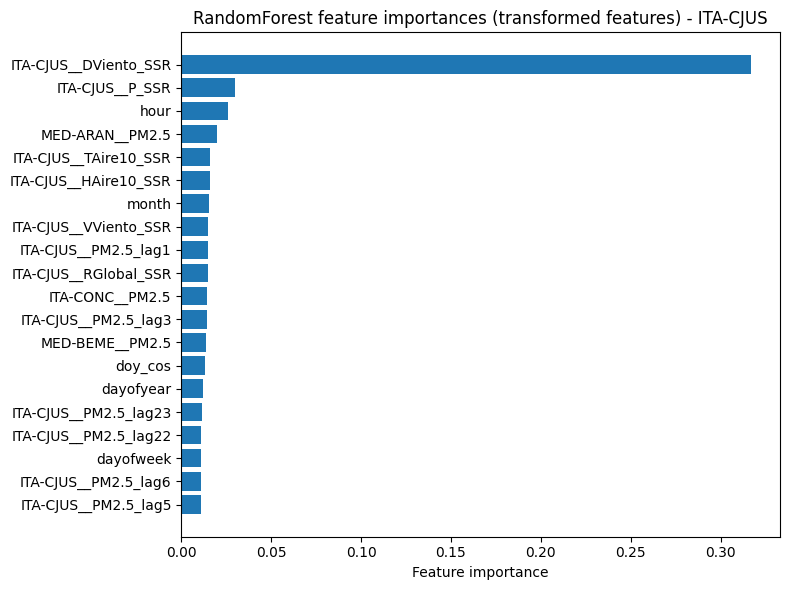

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

importances_ita_cjus = best_rf_pipeline_ita_cjus.named_steps["rf"].feature_importances_
feature_names = preproc_ita_cjus.feature_cols_

# sort
indices_ita_cjus = np.argsort(importances_ita_cjus)[::-1]

# how many features to show
n_top = 20
top_idx_ita_cjus = indices_ita_cjus[:n_top]

plt.figure(figsize=(8, 6))
plt.barh(range(n_top), importances_ita_cjus[top_idx_ita_cjus][::-1])
plt.yticks(range(n_top), [feature_names[i] for i in top_idx_ita_cjus][::-1])
plt.xlabel("Feature importance")
plt.title("RandomForest feature importances (transformed features) - ITA-CJUS")
plt.tight_layout()
plt.show()

In [20]:
importances_ita_cjus.shape

(72,)

In [ ]:
best_rf_pipeline_ita_cjus['pca'].components_

(72, 194)

In [ ]:
best_rf_pipeline_ita_cjus['rf']

RandomForestRegressor(max_depth=50, min_samples_split=10)

In [26]:
# Create a dataframe with the PCA coefficients and feature names
pca_components_ita_cjus = best_rf_pipeline_ita_cjus['pca'].components_
pca_feature_names_ita_cjus = [f'PC{i+1}' for i in range(pca_components_ita_cjus.shape[0])]
df_pca_ita_cjus = pd.DataFrame(pca_components_ita_cjus, index=pca_feature_names_ita_cjus, columns=preproc_ita_cjus.feature_cols_)

In [27]:
df_pca_ita_cjus

,ITA-CJUS__DViento_SSR,ITA-CJUS__HAire10_SSR,ITA-CJUS__P_SSR,ITA-CJUS__RGlobal_SSR,ITA-CJUS__TAire10_SSR,ITA-CJUS__VViento_SSR,MED-ARAN__PM2.5,MED-BEME__PM2.5,ITA-CONC__PM2.5,CAL-JOAR__PM2.5,...,MED-BEME__PM2.5_rollmean24,MED-BEME__PM2.5_rollmean48,ITA-CONC__PM2.5_rollmean3,ITA-CONC__PM2.5_rollmean6,ITA-CONC__PM2.5_rollmean24,ITA-CONC__PM2.5_rollmean48,CAL-JOAR__PM2.5_rollmean3,CAL-JOAR__PM2.5_rollmean6,CAL-JOAR__PM2.5_rollmean24,CAL-JOAR__PM2.5_rollmean48
PC1,0.013521,0.051412,0.047301,-0.020763,-0.054446,-0.035438,0.110134,0.098591,0.105305,0.100391,...,0.112336,0.113344,0.110292,0.107667,0.114842,0.113668,0.110451,0.110163,0.109073,0.108813
PC2,0.008361,-0.134251,-0.105918,0.068472,0.138307,0.101826,0.022755,-0.020320,0.038344,0.050220,...,0.056591,0.057597,0.057432,0.074218,0.071885,0.071023,0.062188,0.076224,0.091526,0.091145
PC3,0.031522,0.067507,-0.048240,-0.158171,-0.060636,0.030497,0.028546,0.035508,-0.010325,0.023449,...,0.007945,0.015479,-0.041471,-0.044378,0.014875,0.019694,-0.007767,-0.019734,0.023924,0.027066
PC4,0.059622,0.012170,0.095777,-0.002904,-0.016042,0.020236,0.005176,-0.002298,0.021886,0.066801,...,-0.100184,-0.101720,0.019633,-0.013218,-0.053360,-0.056261,0.088367,0.067749,0.023658,0.017252
PC5,0.000942,-0.037254,0.053515,0.050374,0.023232,0.021101,-0.059368,-0.062641,-0.061920,-0.026780,...,-0.022755,0.030499,-0.093923,-0.083131,0.015184,0.051458,-0.048427,-0.035972,0.042445,0.071900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PC68,-0.052189,-0.027108,-0.005518,-0.142893,-0.006231,0.136822,0.063424,0.181365,-0.010888,0.262941,...,0.018085,0.080841,-0.027562,-0.026481,-0.016832,0.039236,-0.059018,-0.010576,-0.002109,0.022802
PC69,-0.011644,-0.035362,0.036014,0.081184,0.029968,0.025199,-0.070451,-0.197363,0.047492,0.317612,...,0.074635,0.017131,-0.045100,-0.001596,-0.043376,-0.076832,-0.093681,-0.012236,-0.047879,-0.079138
PC70,-0.000543,-0.040960,-0.120091,0.108689,0.049737,-0.091340,-0.046674,-0.119873,-0.126381,0.020668,...,0.006753,0.035907,0.015459,0.012931,-0.030515,-0.006768,0.017464,-0.006374,-0.012298,-0.005434
PC71,0.010065,-0.071454,0.001713,0.019921,0.067612,0.050199,-0.095492,0.003872,0.268658,-0.046710,...,-0.007184,0.002947,-0.108895,-0.010845,-0.003787,0.004170,0.014202,-0.014686,0.001930,0.007757


In [29]:
# Get the most important features for the first principal component
df_pca_ita_cjus.loc['PC1'].sort_values(ascending=False).head(10)

MED-ARAN__PM2.5_rollmean6     0.124145
MED-ARAN__PM2.5_rollmean3     0.123185
MED-BEME__PM2.5_rollmean6     0.121230
ITA-CJUS__PM2.5_rollmean6     0.119970
ITA-CJUS__PM2.5_rollmean3     0.118648
MED-ARAN__PM2.5_rollmean24    0.117851
MED-BEME__PM2.5_rollmean3     0.117780
MED-ARAN__PM2.5_lag2          0.116800
MED-ARAN__PM2.5_rollmean48    0.115536
MED-ARAN__PM2.5_lag1          0.115243
Name: PC1, dtype: float64

## BAR-TORR

In [5]:
preproc = AirQualityPreprocessor(
    target_col="BAR-TORR",      # or any other station column
    quality_col=None,           # <-- no quality column in this dataset
    datetime_col="Fecha_Hora",  # the time column in your file
    freq='1H',                  # or "1H" if you want to enforce hourly frequency
    max_lag=48,                 # pm25_lag1..24 and lags for other numeric vars
    lag_other_cols=None,        # None = lag all numeric columns except target
    missing_col_threshold=0.5, # or e.g. 0.5 to drop very sparse columns
)


# VERY IMPORTANT: fit ONLY on training data (2019–2021)
preproc.fit(df_train)

/home/manuel/Documents/Maestria_Analitica/Semestre_II/AQI_Predict/air_quality_preprocessor_forecasting.py:74: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.asfreq(self.freq)
/home/manuel/Documents/Maestria_Analitica/Semestre_II/AQI_Predict/air_quality_preprocessor_forecasting.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{base_col}_lag{lag}"] = df[base_col].shift(lag)
/home/manuel/Documents/Maestria_Analitica/Semestre_II/AQI_Predict/air_quality_preprocessor_forecasting.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

AirQualityPreprocessor(datetime_col='Fecha_Hora', freq='1H', max_lag=48,
                       missing_col_threshold=0.5, target_col='BAR-TORR')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52608 entries, 0 to 52607
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Fecha_Hora  52608 non-null  datetime64[ns]
 1   BAR-TORR    49250 non-null  float64       
 2   GIR-SOSN    16804 non-null  float64       
 3   GIR-EPM     34004 non-null  float64       
 4   COP-CVID    50965 non-null  float64       
 5   BEL-FEVE    50181 non-null  float64       
 6   MED-ARAN    50655 non-null  float64       
 7   MED-PBLQ    22670 non-null  float64       
 8   MED-SCRI    50304 non-null  float64       
 9   MED-FISC    40065 non-null  float64       
 10  MED-UNNV    9810 non-null   float64       
 11  MED-VILL    50039 non-null  float64       
 12  CEN-TRAF    49896 non-null  float64       
 13  MED-BEME    50916 non-null  float64       
 14  MED-SELE    47933 non-null  float64       
 15  MED-PROV    10122 non-null  float64       
 16  MED-ALTA    50015 non-

In [7]:
# Train
X_train, y_train, mask_train_valid, idx_train = preproc.transform(df_train)
# X_train = X_train[mask_train_valid]
# y_train = y_train[mask_train_valid]

# Test (2022–2023)
X_test, y_test, mask_test_valid, idx_test = preproc.transform(df_test)
# X_test_valid = X_test[mask_test_valid]
# y_test_valid = y_test[mask_test_valid]

# Validation (2024)
X_val, y_val, mask_val_valid, idx_val = preproc.transform(df_val)
# X_val_valid = X_val[mask_val_valid]
# y_val_valid = y_val[mask_val_valid]

/home/manuel/Documents/Maestria_Analitica/Semestre_II/AQI_Predict/air_quality_preprocessor_forecasting.py:74: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.asfreq(self.freq)
/home/manuel/Documents/Maestria_Analitica/Semestre_II/AQI_Predict/air_quality_preprocessor_forecasting.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{base_col}_lag{lag}"] = df[base_col].shift(lag)
/home/manuel/Documents/Maestria_Analitica/Semestre_II/AQI_Predict/air_quality_preprocessor_forecasting.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

In [8]:
# Base feature matrices as DataFrames
X_train_full = X_train[preproc.feature_cols_]
X_test_full  = X_test[preproc.feature_cols_]
X_val_full   = X_val[preproc.feature_cols_]

y_train_full = y_train
y_test_full  = y_test
y_val_full   = y_val

In [9]:
# --- build 6-hour-ahead targets ---

# Training: X at time t, y at time t+6
X_train_h = X_train_full.iloc[:-h]        # drop last h rows (no future target)
y_train_h = y_train_full[h:]             # drop first h rows

# keep only rows where the 6h-ahead target is valid (not NaN)
mask_train_h = ~np.isnan(y_train_h)
X_train_h = X_train_h.loc[mask_train_h]
y_train_h = y_train_h[mask_train_h]

# Test: same logic
X_test_h = X_test_full.iloc[:-h]
y_test_h = y_test_full[h:]

mask_test_h = ~np.isnan(y_test_h)
X_test_h = X_test_h.loc[mask_test_h]
y_test_h = y_test_h[mask_test_h]

# Validation: same logic
X_val_h = X_val_full.iloc[:-h]
y_val_h = y_val_full[h:]

mask_val_h = ~np.isnan(y_val_h)
X_val_h = X_val_h.loc[mask_val_h]
y_val_h = y_val_h[mask_val_h]

In [ ]:
# PCA library
from sklearn.decomposition import PCA

numeric_cols = preproc.numeric_cols_
categorical_cols = preproc.categorical_cols_

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),  # RF-specific choice
    ("scaler", StandardScaler())                    # scaling optional for RF
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

col_transformer = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

rf_pipeline = Pipeline([
    ("cols", col_transformer),
    ("pca", PCA(n_components=0.95)),
    ("rf", RandomForestRegressor())
])

param_grid = {
    'rf__n_estimators': [100, 250, 500],
    'rf__max_depth': [50, 100, 150],
    'rf__min_samples_split': [2, 5, 10],
    'rf__criterion': ['squared_error']
}



grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=2)
grid_search.fit(X_train_h, y_train_h)

best_rf_pipeline = grid_search.best_estimator_
print("Best parameters found: ", grid_search.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END rf__criterion=squared_error, rf__max_depth=50, rf__min_samples_split=2, rf__n_estimators=100; total time= 9.2min
[CV] END rf__criterion=squared_error, rf__max_depth=50, rf__min_samples_split=2, rf__n_estimators=100; total time= 9.3min
[CV] END rf__criterion=squared_error, rf__max_depth=50, rf__min_samples_split=2, rf__n_estimators=100; total time= 9.3min
[CV] END rf__criterion=squared_error, rf__max_depth=50, rf__min_samples_split=2, rf__n_estimators=100; total time= 9.6min
[CV] END rf__criterion=squared_error, rf__max_depth=50, rf__min_samples_split=2, rf__n_estimators=100; total time= 9.9min
[CV] END rf__criterion=squared_error, rf__max_depth=50, rf__min_samples_split=5, rf__n_estimators=100; total time= 8.7min
[CV] END rf__criterion=squared_error, rf__max_depth=50, rf__min_samples_split=5, rf__n_estimators=100; total time= 9.2min
[CV] END rf__criterion=squared_error, rf__max_depth=50, rf__min_samples_split=2, rf_

/home/manuel/Documents/Maestria_Analitica/Semestre_II/AQI_Predict/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END rf__criterion=squared_error, rf__max_depth=50, rf__min_samples_split=10, rf__n_estimators=100; total time= 8.1min
[CV] END rf__criterion=squared_error, rf__max_depth=50, rf__min_samples_split=2, rf__n_estimators=500; total time=48.4min
[CV] END rf__criterion=squared_error, rf__max_depth=50, rf__min_samples_split=10, rf__n_estimators=100; total time= 8.6min
[CV] END rf__criterion=squared_error, rf__max_depth=50, rf__min_samples_split=10, rf__n_estimators=100; total time= 8.2min
[CV] END rf__criterion=squared_error, rf__max_depth=50, rf__min_samples_split=5, rf__n_estimators=500; total time=45.9min
[CV] END rf__criterion=squared_error, rf__max_depth=50, rf__min_samples_split=5, rf__n_estimators=500; total time=43.6min
[CV] END rf__criterion=squared_error, rf__max_depth=50, rf__min_samples_split=10, rf__n_estimators=250; total time=20.5min
[CV] END rf__criterion=squared_error, rf__max_depth=50, rf__min_samples_split=10, rf__n_estimators=250; total time=20.7min
[CV] END rf__criter

In [13]:
# Evaluate on 2022–2023
y_test_pred = best_rf_pipeline.predict(X_test_h)
rmse_test = root_mean_squared_error(y_test_h, y_test_pred)
# Evaluate on 2024
y_val_pred = best_rf_pipeline.predict(X_val_h)
rmse_val = root_mean_squared_error(y_val_h, y_val_pred)
print("RMSE test (2022–2023):", rmse_test)
print("RMSE val  (2024):", rmse_val)

# Evaluate R2
r2_train = r2_score(y_train_h, best_rf_pipeline.predict(X_train_h))
r2_test = r2_score(y_test_h, y_test_pred)
r2_val = r2_score(y_val_h, y_val_pred)
print("R2 train (2019–2021):", r2_train)
print("R2 test (2022–2023):", r2_test)
print("R2 val  (2024):", r2_val)

RMSE test (2022–2023): 5.572220278834976
RMSE val  (2024): 6.498697713415497
R2 train (2019–2021): 0.9599270132418527
R2 test (2022–2023): 0.434154047300507
R2 val  (2024): 0.5466678821763609


In [14]:
preproc.feature_cols_

['GIR-SOSN',
 'COP-CVID',
 'BEL-FEVE',
 'MED-ARAN',
 'MED-SCRI',
 'MED-FISC',
 'MED-VILL',
 'CEN-TRAF',
 'MED-BEME',
 'MED-SELE',
 'MED-ALTA',
 'MED-TESO',
 'ITA-CJUS',
 'MED-LAYE',
 'ITA-CONC',
 'ENV-HOSP',
 'EST-HOSP',
 'SUR-TRAF',
 'SAB-RAME',
 'CAL-LASA',
 'CAL-JOAR',
 'hour',
 'dayofweek',
 'month',
 'dayofyear',
 'hour_sin',
 'hour_cos',
 'doy_sin',
 'doy_cos',
 'BAR-TORR_lag1',
 'BAR-TORR_lag2',
 'BAR-TORR_lag3',
 'BAR-TORR_lag4',
 'BAR-TORR_lag5',
 'BAR-TORR_lag6',
 'BAR-TORR_lag21',
 'BAR-TORR_lag22',
 'BAR-TORR_lag23',
 'BAR-TORR_lag24',
 'BAR-TORR_lag47',
 'BAR-TORR_lag48',
 'GIR-SOSN_lag1',
 'GIR-SOSN_lag2',
 'GIR-SOSN_lag3',
 'GIR-SOSN_lag4',
 'GIR-SOSN_lag5',
 'GIR-SOSN_lag6',
 'GIR-SOSN_lag21',
 'GIR-SOSN_lag22',
 'GIR-SOSN_lag23',
 'GIR-SOSN_lag24',
 'GIR-SOSN_lag47',
 'GIR-SOSN_lag48',
 'COP-CVID_lag1',
 'COP-CVID_lag2',
 'COP-CVID_lag3',
 'COP-CVID_lag4',
 'COP-CVID_lag5',
 'COP-CVID_lag6',
 'COP-CVID_lag21',
 'COP-CVID_lag22',
 'COP-CVID_lag23',
 'COP-CVID_lag24',
 '

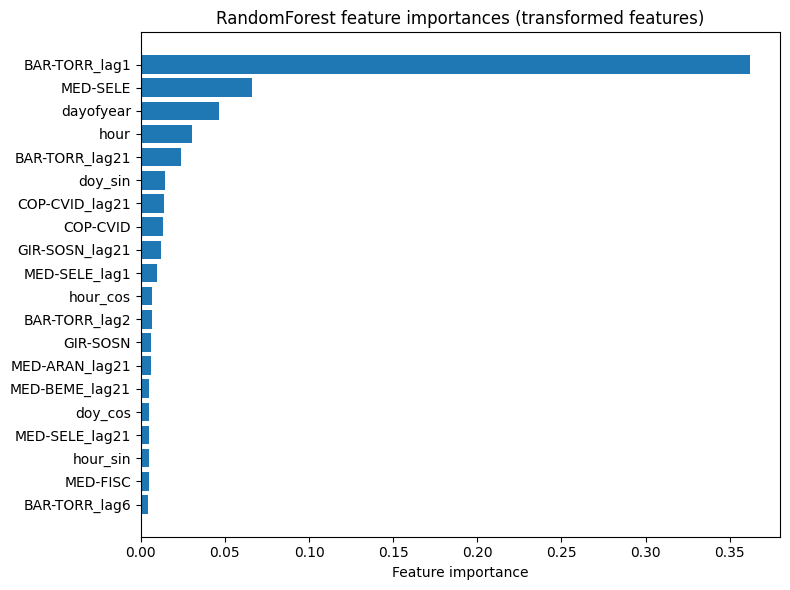

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

importances = best_rf_pipeline.named_steps["rf"].feature_importances_
feature_names = preproc.feature_cols_

# sort
indices = np.argsort(importances)[::-1]

# how many features to show
n_top = 20
top_idx = indices[:n_top]

plt.figure(figsize=(8, 6))
plt.barh(range(n_top), importances[top_idx][::-1])
plt.yticks(range(n_top), [feature_names[i] for i in top_idx][::-1])
plt.xlabel("Feature importance")
plt.title("RandomForest feature importances (transformed features)")
plt.tight_layout()
plt.show()

In [23]:
top_idx

array([ 29,   9,  24,  21,  35,  27,  59,   1,  47, 149,  26,  30,   0,
        83, 143,  28, 155,  25,   5,  34])

In [16]:
# Create an importances dataframe

importances_df=pd.DataFrame(importances, index=feature_names, columns=['Importancia'])

In [17]:
important_features=importances_df.sort_values(by='Importancia',ascending=False).head(20).index.to_list()

In [18]:
importances_df.sort_values(by='Importancia',ascending=False).head(20).index.to_list()

['BAR-TORR_lag1',
 'MED-SELE',
 'dayofyear',
 'hour',
 'BAR-TORR_lag21',
 'doy_sin',
 'COP-CVID_lag21',
 'COP-CVID',
 'GIR-SOSN_lag21',
 'MED-SELE_lag1',
 'hour_cos',
 'BAR-TORR_lag2',
 'GIR-SOSN',
 'MED-ARAN_lag21',
 'MED-BEME_lag21',
 'doy_cos',
 'MED-SELE_lag21',
 'hour_sin',
 'MED-FISC',
 'BAR-TORR_lag6']

In [19]:
important_features_list = [feat.split('__')[-1] for feat in important_features]

In [20]:
important_features_list

['BAR-TORR_lag1',
 'MED-SELE',
 'dayofyear',
 'hour',
 'BAR-TORR_lag21',
 'doy_sin',
 'COP-CVID_lag21',
 'COP-CVID',
 'GIR-SOSN_lag21',
 'MED-SELE_lag1',
 'hour_cos',
 'BAR-TORR_lag2',
 'GIR-SOSN',
 'MED-ARAN_lag21',
 'MED-BEME_lag21',
 'doy_cos',
 'MED-SELE_lag21',
 'hour_sin',
 'MED-FISC',
 'BAR-TORR_lag6']

In [60]:
X_train_h.columns.to_list()

['GIR-SOSN',
 'COP-CVID',
 'BEL-FEVE',
 'MED-ARAN',
 'MED-SCRI',
 'MED-FISC',
 'MED-VILL',
 'CEN-TRAF',
 'MED-BEME',
 'MED-SELE',
 'MED-ALTA',
 'MED-TESO',
 'ITA-CJUS',
 'MED-LAYE',
 'ITA-CONC',
 'ENV-HOSP',
 'EST-HOSP',
 'SUR-TRAF',
 'SAB-RAME',
 'CAL-LASA',
 'CAL-JOAR',
 'hour',
 'dayofweek',
 'month',
 'dayofyear',
 'hour_sin',
 'hour_cos',
 'doy_sin',
 'doy_cos',
 'BAR-TORR_lag1',
 'BAR-TORR_lag2',
 'BAR-TORR_lag3',
 'BAR-TORR_lag4',
 'BAR-TORR_lag5',
 'BAR-TORR_lag6',
 'BAR-TORR_lag21',
 'BAR-TORR_lag22',
 'BAR-TORR_lag23',
 'BAR-TORR_lag24',
 'BAR-TORR_lag47',
 'BAR-TORR_lag48',
 'GIR-SOSN_lag1',
 'GIR-SOSN_lag2',
 'GIR-SOSN_lag3',
 'GIR-SOSN_lag4',
 'GIR-SOSN_lag5',
 'GIR-SOSN_lag6',
 'GIR-SOSN_lag21',
 'GIR-SOSN_lag22',
 'GIR-SOSN_lag23',
 'GIR-SOSN_lag24',
 'GIR-SOSN_lag47',
 'GIR-SOSN_lag48',
 'COP-CVID_lag1',
 'COP-CVID_lag2',
 'COP-CVID_lag3',
 'COP-CVID_lag4',
 'COP-CVID_lag5',
 'COP-CVID_lag6',
 'COP-CVID_lag21',
 'COP-CVID_lag22',
 'COP-CVID_lag23',
 'COP-CVID_lag24',
 '

In [69]:
# Prepare reduced feature matrices
variables = important_features_list
# variables = ['BAR-TORR_lag1', 'BAR-TORR_lag24', 'BAR-TORR_lag48','hour',
#  'dayofweek',
#  'month',
#  'dayofyear',
#  'hour_sin',
#  'hour_cos',
#  'doy_sin',
#  'doy_cos',]
X_train_small = X_train_h[variables]
X_test_small  = X_test_h[variables]
X_val_small   = X_val_h[variables]

In [73]:
variables

['BAR-TORR_lag1',
 'MED-SELE',
 'dayofyear',
 'hour',
 'BAR-TORR_lag21',
 'doy_sin',
 'COP-CVID_lag21',
 'COP-CVID',
 'GIR-SOSN_lag21',
 'MED-SELE_lag1',
 'hour_cos',
 'BAR-TORR_lag2',
 'GIR-SOSN',
 'MED-ARAN_lag21',
 'MED-BEME_lag21',
 'doy_cos',
 'MED-SELE_lag21',
 'hour_sin',
 'MED-FISC',
 'BAR-TORR_lag6']

In [70]:
X_train_small

,BAR-TORR_lag1,MED-SELE,dayofyear,hour,BAR-TORR_lag21,doy_sin,COP-CVID_lag21,COP-CVID,GIR-SOSN_lag21,MED-SELE_lag1,hour_cos,BAR-TORR_lag2,GIR-SOSN,MED-ARAN_lag21,MED-BEME_lag21,doy_cos,MED-SELE_lag21,hour_sin,MED-FISC,BAR-TORR_lag6
Fecha_Hora,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,NaN,NaN,1,0,NaN,0.017202,NaN,NaN,NaN,NaN,1.000000e+00,NaN,34.0,NaN,NaN,0.999852,NaN,0.000000,NaN,NaN
2019-01-01 01:00:00,93.66460,NaN,1,1,NaN,0.017202,NaN,NaN,NaN,NaN,9.659258e-01,NaN,54.0,NaN,NaN,0.999852,NaN,0.258819,NaN,NaN
2019-01-01 02:00:00,50.35420,NaN,1,2,NaN,0.017202,NaN,NaN,NaN,NaN,8.660254e-01,93.66460,49.0,NaN,NaN,0.999852,NaN,0.500000,NaN,NaN
2019-01-01 03:00:00,35.06550,NaN,1,3,NaN,0.017202,NaN,NaN,NaN,NaN,7.071068e-01,50.35420,38.0,NaN,NaN,0.999852,NaN,0.707107,NaN,NaN
2019-01-01 04:00:00,29.18590,NaN,1,4,NaN,0.017202,NaN,NaN,NaN,NaN,5.000000e-01,35.06550,29.0,NaN,NaN,0.999852,NaN,0.866025,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-30 14:00:00,9.47877,0.50000,364,14,11.5950,-0.021501,21.1569,7.22548,NaN,15.15710,-8.660254e-01,13.02440,NaN,36.7165,13.4680,0.999769,12.16820,-0.500000,22.0,21.9154
2021-12-30 15:00:00,7.12991,5.46964,364,15,10.4034,-0.021501,21.1079,4.79095,NaN,0.50000,-7.071068e-01,9.47877,NaN,34.2898,50.0455,0.999769,13.49000,-0.707107,25.0,20.9503
2021-12-30 16:00:00,4.73165,1.35940,364,16,12.6980,-0.021501,23.3668,9.51291,NaN,5.46964,-5.000000e-01,7.12991,NaN,50.7942,45.1831,0.999769,9.43178,-0.866025,20.0,17.6246


In [71]:
X_test_small

,BAR-TORR_lag1,MED-SELE,dayofyear,hour,BAR-TORR_lag21,doy_sin,COP-CVID_lag21,COP-CVID,GIR-SOSN_lag21,MED-SELE_lag1,hour_cos,BAR-TORR_lag2,GIR-SOSN,MED-ARAN_lag21,MED-BEME_lag21,doy_cos,MED-SELE_lag21,hour_sin,MED-FISC,BAR-TORR_lag6
Fecha_Hora,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,NaN,12.14040,1,0,NaN,0.017202,NaN,24.62330,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,0.999852,NaN,0.000000,30.0,NaN
2022-01-01 01:00:00,38.03180,16.17420,1,1,NaN,0.017202,NaN,25.79440,NaN,12.14040,9.659258e-01,NaN,NaN,NaN,NaN,0.999852,NaN,0.258819,30.0,NaN
2022-01-01 02:00:00,36.90790,14.83310,1,2,NaN,0.017202,NaN,23.44010,NaN,16.17420,8.660254e-01,38.03180,NaN,NaN,NaN,0.999852,NaN,0.500000,31.0,NaN
2022-01-01 03:00:00,23.06530,14.84350,1,3,NaN,0.017202,NaN,21.09010,NaN,14.83310,7.071068e-01,36.90790,NaN,NaN,NaN,0.999852,NaN,0.707107,28.0,NaN
2022-01-01 04:00:00,19.58000,9.44162,1,4,NaN,0.017202,NaN,18.73340,NaN,14.84350,5.000000e-01,23.06530,NaN,NaN,NaN,0.999852,NaN,0.866025,28.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-30 14:00:00,10.48640,5.30947,364,14,2.32664,-0.021501,14.15950,5.95295,NaN,17.16460,-8.660254e-01,NaN,NaN,15.4878,21.9148,0.999769,34.16240,-0.500000,6.0,3.45119
2023-12-30 15:00:00,15.32380,NaN,364,15,5.78499,-0.021501,10.55480,7.17774,NaN,5.30947,-7.071068e-01,10.48640,NaN,12.9965,26.6621,0.999769,30.08770,-0.707107,7.0,NaN
2023-12-30 16:00:00,11.79150,19.75590,364,16,13.83080,-0.021501,8.18107,8.31997,NaN,NaN,-5.000000e-01,15.32380,NaN,20.0146,32.6073,0.999769,31.32150,-0.866025,10.0,NaN


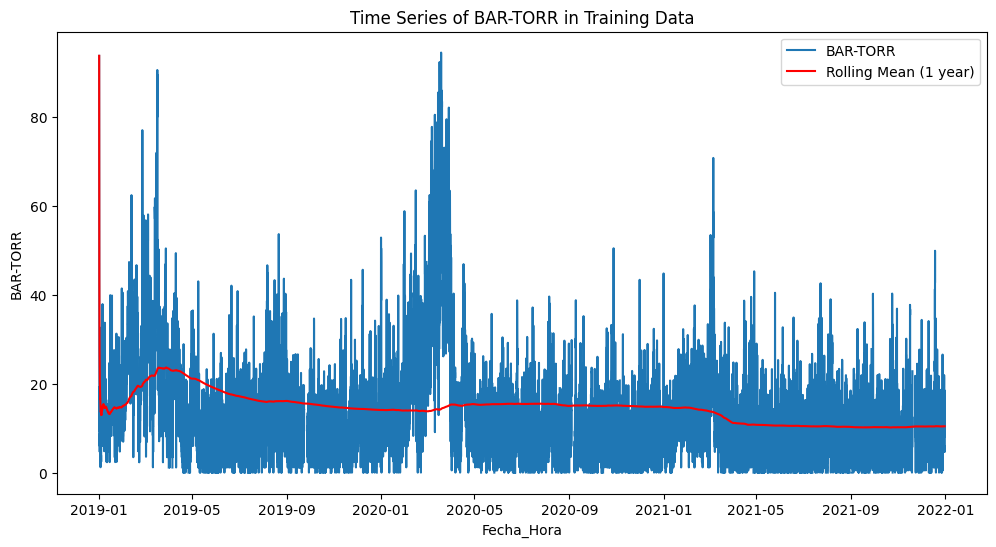

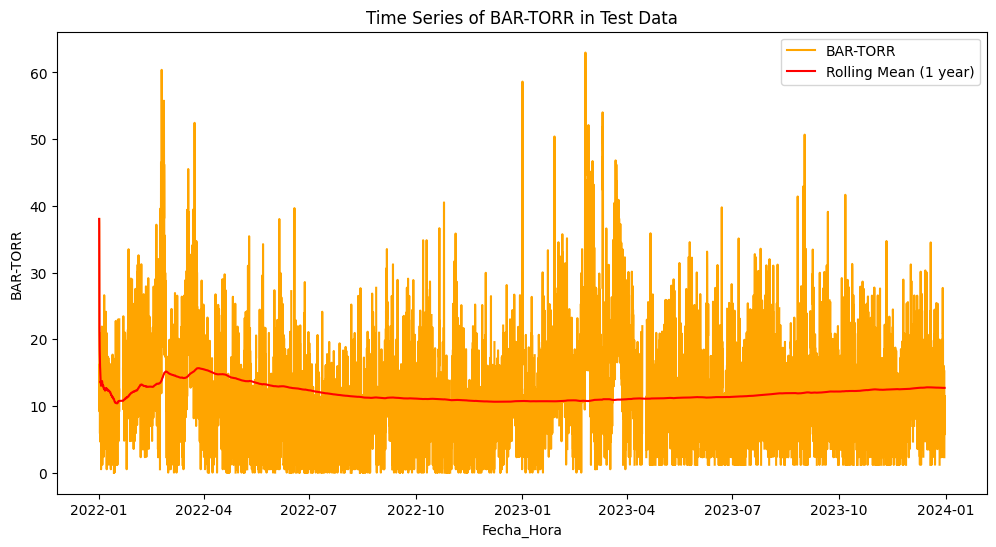

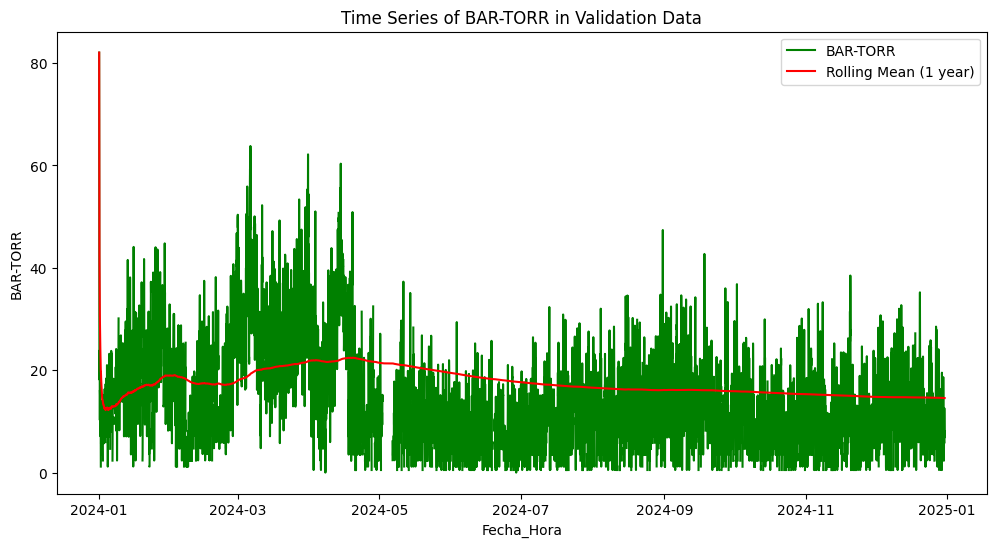

In [55]:
# Plot df_train target variable time series
plt.figure(figsize=(12, 6))
plt.plot(df_train['Fecha_Hora'], df_train['BAR-TORR'], label='BAR-TORR')
# Add rolling mean per year for better visualization
df_train.set_index('Fecha_Hora', inplace=True)
rolling_mean = df_train['BAR-TORR'].rolling(window=24*365, min_periods=1).mean()
plt.plot(rolling_mean.index, rolling_mean, label='Rolling Mean (1 year)', color='red')
df_train.reset_index(inplace=True)
plt.xlabel('Fecha_Hora')
plt.ylabel('BAR-TORR')
plt.title('Time Series of BAR-TORR in Training Data')
plt.legend()
plt.show()

# Plot df_test target variable time series
plt.figure(figsize=(12, 6))
plt.plot(df_test['Fecha_Hora'], df_test['BAR-TORR'], label='BAR-TORR', color='orange')
# Add rolling mean per year for better visualization
df_test.set_index('Fecha_Hora', inplace=True)
rolling_mean_test = df_test['BAR-TORR'].rolling(window=24*365, min_periods=1).mean()
plt.plot(rolling_mean_test.index, rolling_mean_test, label='Rolling Mean (1 year)', color='red')
df_test.reset_index(inplace=True)
plt.xlabel('Fecha_Hora')
plt.ylabel('BAR-TORR')
plt.title('Time Series of BAR-TORR in Test Data')
plt.legend()
plt.show()

# Plot df_val target variable time series
plt.figure(figsize=(12, 6))
plt.plot(df_val['Fecha_Hora'], df_val['BAR-TORR'], label='BAR-TORR', color='green')
# Add rolling mean per year for better visualization
df_val.set_index('Fecha_Hora', inplace=True)
rolling_mean_val = df_val['BAR-TORR'].rolling(window=24*365, min_periods=1).mean()
plt.plot(rolling_mean_val.index, rolling_mean_val, label='Rolling Mean (1 year)', color='red')
df_val.reset_index(inplace=True)
plt.xlabel('Fecha_Hora')
plt.ylabel('BAR-TORR')
plt.title('Time Series of BAR-TORR in Validation Data')
plt.legend()
plt.show()

In [72]:
rf_small = RandomForestRegressor(
    n_estimators=250,
    max_depth=100,
    min_samples_split=2,
    random_state=42,
    criterion="squared_error",
    n_jobs=-1
)
rf_small.fit(X_train_small, y_train_h)

y_train_pred = rf_small.predict(X_train_small)
y_test_pred = rf_small.predict(X_test_small)
y_val_pred  = rf_small.predict(X_val_small)

print("Train R2 (small model):", r2_score(y_train_h, y_train_pred))
print("Test R2 (small model):", r2_score(y_test_h, y_test_pred))
print("Val  R2 (small model):", r2_score(y_val_h,  y_val_pred))

print("Train RMSE (small model):",
      root_mean_squared_error(y_train_h, y_train_pred))
print("Test RMSE (small model):",
      root_mean_squared_error(y_test_h, y_test_pred))
print("Val  RMSE (small model):",
      root_mean_squared_error(y_val_h,  y_val_pred))

Train R2 (small model): 0.958556698555837
Test R2 (small model): 0.4257575708996566
Val  R2 (small model): 0.5207065618366779
Train RMSE (small model): 2.158652130213507
Test RMSE (small model): 5.613410576264297
Val  RMSE (small model): 6.6821902026627935


## COP-CVID

In [51]:
preproc_cop_cvid = AirQualityPreprocessor(
    target_col="COP-CVID",      # or any other station column
    quality_col=None,           # <-- no quality column in this dataset
    datetime_col="Fecha_Hora",  # the time column in your file
    freq='1H',                  # or "1H" if you want to enforce hourly frequency
    max_lag=48,                 # pm25_lag1..24 and lags for other numeric vars
    lag_other_cols=None,        # None = lag all numeric columns except target
    missing_col_threshold=0.5, # or e.g. 0.5 to drop very sparse columns
    scale_numeric=True,
)


# VERY IMPORTANT: fit ONLY on training data (2019–2021)
preproc_cop_cvid.fit(df_train)

/home/manuel/Documents/Maestria_Analitica/Semestre_II/AQI_Predict/air_quality_preprocessor.py:76: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.asfreq(self.freq)
/home/manuel/Documents/Maestria_Analitica/Semestre_II/AQI_Predict/air_quality_preprocessor.py:179: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{base_col}_lag{lag}"] = df[base_col].shift(lag)
/home/manuel/Documents/Maestria_Analitica/Semestre_II/AQI_Predict/air_quality_preprocessor.py:179: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame,

AirQualityPreprocessor(datetime_col='Fecha_Hora', freq='1H', max_lag=48,
                       missing_col_threshold=0.5, target_col='COP-CVID')

In [52]:
# Train
X_train_cop_cvid, y_train_cop_cvid, mask_train_valid_cop_cvid, idx_train_cop_cvid = preproc_cop_cvid.transform(df_train)
X_train_cop_cvid = X_train_cop_cvid[mask_train_valid_cop_cvid]
y_train_cop_cvid = y_train_cop_cvid[mask_train_valid_cop_cvid]

# Test (2022–2023)
X_test_cop_cvid, y_test_cop_cvid, mask_test_valid_cop_cvid, idx_test_cop_cvid = preproc_cop_cvid.transform(df_test)
X_test_cop_cvid = X_test_cop_cvid[mask_test_valid_cop_cvid]
y_test_cop_cvid = y_test_cop_cvid[mask_test_valid_cop_cvid]

# Validation (2024)
X_val_cop_cvid, y_val_cop_cvid, mask_val_valid_cop_cvid, idx_val_cop_cvid = preproc_cop_cvid.transform(df_val)
X_val_cop_cvid = X_val_cop_cvid[mask_val_valid_cop_cvid]
y_val_cop_cvid = y_val_cop_cvid[mask_val_valid_cop_cvid]

/home/manuel/Documents/Maestria_Analitica/Semestre_II/AQI_Predict/air_quality_preprocessor.py:76: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.asfreq(self.freq)
/home/manuel/Documents/Maestria_Analitica/Semestre_II/AQI_Predict/air_quality_preprocessor.py:179: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{base_col}_lag{lag}"] = df[base_col].shift(lag)
/home/manuel/Documents/Maestria_Analitica/Semestre_II/AQI_Predict/air_quality_preprocessor.py:179: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame,

In [53]:
feature_names_transformed_cop_cvid = preproc_cop_cvid.column_transformer_.get_feature_names_out()
print("Transformed feature names:")
for name in feature_names_transformed_cop_cvid:
    print(name)

Transformed feature names:
num__BAR-TORR
num__GIR-SOSN
num__BEL-FEVE
num__MED-ARAN
num__MED-SCRI
num__MED-FISC
num__MED-VILL
num__CEN-TRAF
num__MED-BEME
num__MED-SELE
num__MED-ALTA
num__MED-TESO
num__ITA-CJUS
num__MED-LAYE
num__ITA-CONC
num__ENV-HOSP
num__EST-HOSP
num__SUR-TRAF
num__SAB-RAME
num__CAL-LASA
num__CAL-JOAR
num__hour
num__dayofweek
num__month
num__dayofyear
num__hour_sin
num__hour_cos
num__doy_sin
num__doy_cos
num__COP-CVID_lag1
num__COP-CVID_lag2
num__COP-CVID_lag3
num__COP-CVID_lag4
num__COP-CVID_lag5
num__COP-CVID_lag6
num__COP-CVID_lag7
num__COP-CVID_lag8
num__COP-CVID_lag9
num__COP-CVID_lag10
num__COP-CVID_lag11
num__COP-CVID_lag12
num__COP-CVID_lag13
num__COP-CVID_lag14
num__COP-CVID_lag15
num__COP-CVID_lag16
num__COP-CVID_lag17
num__COP-CVID_lag18
num__COP-CVID_lag19
num__COP-CVID_lag20
num__COP-CVID_lag21
num__COP-CVID_lag22
num__COP-CVID_lag23
num__COP-CVID_lag24
num__COP-CVID_lag25
num__COP-CVID_lag26
num__COP-CVID_lag27
num__COP-CVID_lag28
num__COP-CVID_lag29
num

In [54]:
# Train on 2019–2021
rf_cop_cvid = RandomForestRegressor(
    n_estimators=250,
    max_depth=150,
    random_state=42,
    criterion="squared_error",
    n_jobs=-1
)
rf_cop_cvid.fit(X_train_cop_cvid, y_train_cop_cvid)

# Evaluate on 2022–2023
y_test_pred_cop_cvid = rf_cop_cvid.predict(X_test_cop_cvid)
rmse_test_cop_cvid = root_mean_squared_error(y_test_cop_cvid, y_test_pred_cop_cvid)
# Evaluate on 2024
y_val_pred_cop_cvid = rf_cop_cvid.predict(X_val_cop_cvid)
rmse_val_cop_cvid = root_mean_squared_error(y_val_cop_cvid, y_val_pred_cop_cvid)
print("RMSE test (2022–2023):", rmse_test_cop_cvid)
print("RMSE val  (2024):", rmse_val_cop_cvid)

# Evaluate R2
r2_test_cop_cvid = r2_score(y_test_cop_cvid, y_test_pred_cop_cvid)
r2_val_cop_cvid = r2_score(y_val_cop_cvid, y_val_pred_cop_cvid)
print("R2 test (2022–2023):", r2_test_cop_cvid)
print("R2 val  (2024):", r2_val_cop_cvid)

RMSE test (2022–2023): 4.3379219736023735
RMSE val  (2024): 4.186628418970791
R2 test (2022–2023): 0.6799147655803969
R2 val  (2024): 0.7918526864704262


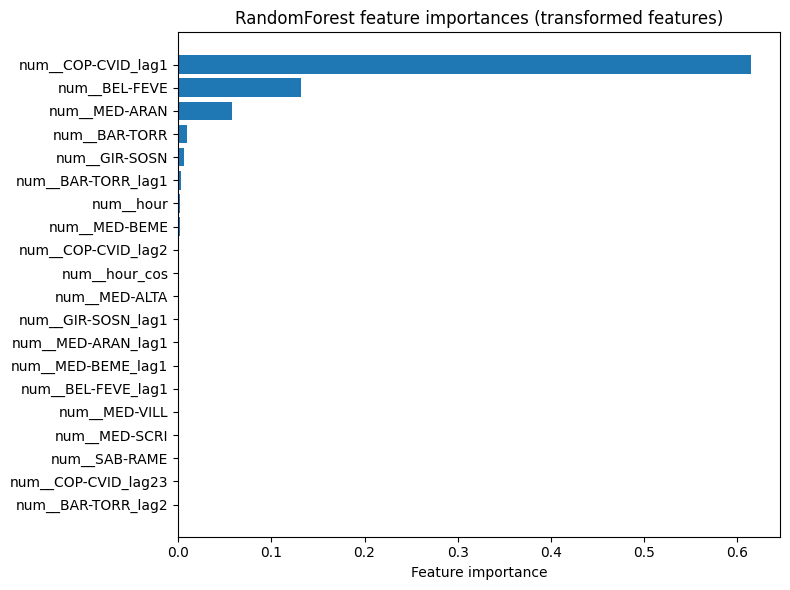

In [55]:
importances_cop_cvid = rf_cop_cvid.feature_importances_
feature_names_cop_cvid = preproc_cop_cvid.column_transformer_.get_feature_names_out()

# sort
indices_cop_cvid = np.argsort(importances_cop_cvid)[::-1]

# how many features to show
n_top = 20
top_idx_cop_cvid = indices_cop_cvid[:n_top]

plt.figure(figsize=(8, 6))
plt.barh(range(n_top), importances_cop_cvid[top_idx_cop_cvid][::-1])
plt.yticks(range(n_top), [feature_names_cop_cvid[i] for i in top_idx_cop_cvid][::-1])
plt.xlabel("Feature importance")
plt.title("RandomForest feature importances (transformed features)")
plt.tight_layout()
plt.show()

In [56]:
# Create an importances dataframe

importances_df_cop_cvid=pd.DataFrame(importances_cop_cvid, index=feature_names_cop_cvid, columns=['Importancia'])

In [57]:
important_features_cop_cvid=importances_df_cop_cvid.sort_values(by='Importancia',ascending=False).head(20).index.to_list()

In [58]:
importances_df_cop_cvid.sort_values(by='Importancia',ascending=False).head(20).index.to_list()

['num__COP-CVID_lag1',
 'num__BEL-FEVE',
 'num__MED-ARAN',
 'num__BAR-TORR',
 'num__GIR-SOSN',
 'num__BAR-TORR_lag1',
 'num__hour',
 'num__MED-BEME',
 'num__COP-CVID_lag2',
 'num__hour_cos',
 'num__MED-ALTA',
 'num__GIR-SOSN_lag1',
 'num__MED-ARAN_lag1',
 'num__MED-BEME_lag1',
 'num__BEL-FEVE_lag1',
 'num__MED-VILL',
 'num__MED-SCRI',
 'num__SAB-RAME',
 'num__COP-CVID_lag23',
 'num__BAR-TORR_lag2']

In [59]:
important_features_list_cop_cvid = [feat.split('__')[-1] for feat in important_features_cop_cvid]

In [60]:
important_features_list_cop_cvid

['COP-CVID_lag1',
 'BEL-FEVE',
 'MED-ARAN',
 'BAR-TORR',
 'GIR-SOSN',
 'BAR-TORR_lag1',
 'hour',
 'MED-BEME',
 'COP-CVID_lag2',
 'hour_cos',
 'MED-ALTA',
 'GIR-SOSN_lag1',
 'MED-ARAN_lag1',
 'MED-BEME_lag1',
 'BEL-FEVE_lag1',
 'MED-VILL',
 'MED-SCRI',
 'SAB-RAME',
 'COP-CVID_lag23',
 'BAR-TORR_lag2']

In [61]:
X_train_small_cop_cvid = X_train_cop_cvid[:, top_idx_cop_cvid[:15]]
X_test_small_cop_cvid  = X_test_cop_cvid[:,  top_idx_cop_cvid[:15]]
X_val_small_cop_cvid   = X_val_cop_cvid[:,   top_idx_cop_cvid[:15]]

In [62]:
rf_small_cop_cvid = RandomForestRegressor(
    n_estimators=250,
    max_depth=150,
    random_state=42,
    criterion="squared_error",
    n_jobs=-1
)
rf_small_cop_cvid.fit(X_train_small_cop_cvid, y_train_cop_cvid)

y_test_pred_cop_cvid = rf_small_cop_cvid.predict(X_test_small_cop_cvid)
y_val_pred_cop_cvid  = rf_small_cop_cvid.predict(X_val_small_cop_cvid)

print("Test R2 (small model):", r2_score(y_test_cop_cvid, y_test_pred_cop_cvid))
print("Val  R2 (small model):", r2_score(y_val_cop_cvid,  y_val_pred_cop_cvid))
print("Test RMSE (small model):",
      root_mean_squared_error(y_test_cop_cvid, y_test_pred_cop_cvid))
print("Val  RMSE (small model):",
      root_mean_squared_error(y_val_cop_cvid,  y_val_pred_cop_cvid))

Test R2 (small model): 0.6762065700451655
Val  R2 (small model): 0.7926445954372917
Test RMSE (small model): 4.36297708442229
Val  RMSE (small model): 4.178656689767312
